In [1]:
!nvidia-smi

Wed Aug  5 06:02:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
VERSION = "1.5"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  31000      0 --:--:-- --:--:-- --:--:-- 31000
Updating... This may take around 2 minutes.
Uninstalling torch-1.6.0+cu101:


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow

In [277]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers_dict = nn.ModuleDict({
            'conv2D_1' : nn.Conv2d(3, 64, 3, padding=1),
            'conv2D_1_same' : nn.Conv2d(64, 64, 3, padding=1),
            'conv2D_2' : nn.Conv2d(64, 128, 3, padding=1),
            'conv2D_2_same' : nn.Conv2d(128, 128, 3, padding=1),
            'conv2D_3' : nn.Conv2d(128, 256, 3, padding=1),
            'conv2D_3_same_1' : nn.Conv2d(256, 256, 3, padding=1),
            'conv2D_3_same_2' : nn.Conv2d(256, 256, 3, padding=1),
            'conv2D_4' : nn.Conv2d(256, 512, 3, padding=1),
            'conv2D_4_same_1' : nn.Conv2d(512, 512, 3, padding=1),
            'conv2D_4_same_2' : nn.Conv2d(512, 512, 3, padding=1),
            'conv2D_4_same_3' : nn.Conv2d(512, 512, 3, padding=1),
            'conv2D_4_same_4' : nn.Conv2d(512, 512, 3, padding=1),
            'conv2D_4_same_5' : nn.Conv2d(512, 512, 3, padding=1),
            'maxPool2D' : nn.MaxPool2d(2, 2),
            'batchNorm_1' : nn.BatchNorm2d(64),
            'batchNorm_2' : nn.BatchNorm2d(128),
            'batchNorm_3' : nn.BatchNorm2d(256),
            'batchNorm_4' : nn.BatchNorm2d(512),
        })

        # for key, value in self.layers_dict.items():
        #     self.register_parameter(key, )

        # self.conv2D_1 = nn.Conv2d(3, 64, 3, padding=1)
        # self.conv2D_1_same = nn.Conv2d(64, 64, 3, padding=1)
        # self.conv2D_2 = nn.Conv2d(64, 128, 3, padding=1)
        # self.conv2D_2_same = nn.Conv2d(128, 128, 3, padding=1)
        
        # self.conv2D_3 = nn.Conv2d(128, 256, 3, padding=1)
        # self.conv2D_3_same = nn.Conv2d(256, 256, 3, padding=1)
        # self.conv2D_3_same = nn.Conv2d(256, 256, 3, padding=1)
        # self.conv2D_3_same = nn.Conv2d(256, 256, 3, padding=1)

        # self.conv2D_4 = nn.Conv2d(256, 512, 3, padding=1)
        # self.conv2D_4_same = nn.Conv2d(512, 512, 3, padding=1)
        # self.maxPool2D = nn.MaxPool2d(2, 2)
        # self.output_shape = None
        # self.forward(torch.FloatTensor(np.random.rand(1, 3, 224, 224)))
    
    def forward(self, x):
        x = F.leaky_relu(self.layers_dict['conv2D_1'](x))
        x = F.leaky_relu(self.layers_dict['conv2D_1_same'](x))
        x = self.layers_dict['maxPool2D'](x)

        x = F.leaky_relu(self.layers_dict['conv2D_2'](x))
        x = F.leaky_relu(self.layers_dict['conv2D_2_same'](x))
        x = self.layers_dict['maxPool2D'](x)

        x = F.leaky_relu(self.layers_dict['conv2D_3'](x))

        for i in range(2):
            x = F.leaky_relu(self.layers_dict['conv2D_3_same_{}'.format(i + 1)](x))
        
        x = self.layers_dict['maxPool2D'](x)

        x = F.leaky_relu(self.layers_dict['conv2D_4'](x))
        
        for i in range(2):
            x = F.leaky_relu(self.layers_dict['conv2D_4_same_{}'.format(i + 1)](x))
        
        x = self.layers_dict['maxPool2D'](x)
        
        for i in range(3):
            x = F.leaky_relu(self.layers_dict['conv2D_4_same_{}'.format(i + 3)](x))
        
        x = self.layers_dict['maxPool2D'](x)
        
        
        return x

In [278]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)

print('VGG-16 Encoder')
summary(encoder, (3, 416, 416))

VGG-16 Encoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 416, 416]           1,792
            Conv2d-2         [-1, 64, 416, 416]          36,928
         MaxPool2d-3         [-1, 64, 208, 208]               0
            Conv2d-4        [-1, 128, 208, 208]          73,856
            Conv2d-5        [-1, 128, 208, 208]         147,584
         MaxPool2d-6        [-1, 128, 104, 104]               0
            Conv2d-7        [-1, 256, 104, 104]         295,168
            Conv2d-8        [-1, 256, 104, 104]         590,080
            Conv2d-9        [-1, 256, 104, 104]         590,080
        MaxPool2d-10          [-1, 256, 52, 52]               0
           Conv2d-11          [-1, 512, 52, 52]       1,180,160
           Conv2d-12          [-1, 512, 52, 52]       2,359,808
           Conv2d-13          [-1, 512, 52, 52]       2,359,808
        MaxPool2d-14    

In [279]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers_dict = nn.ModuleDict({
            'conv2DTrans_1_same_1' : nn.ConvTranspose2d(512, 512, 3, padding=1),
            'conv2DTrans_1_same_2' : nn.ConvTranspose2d(512, 512, 3, padding=1),
            'conv2DTrans_1_same_3' : nn.ConvTranspose2d(512, 512, 3, padding=1),
            'conv2DTrans_1_same_4' : nn.ConvTranspose2d(512, 512, 3, padding=1),
            'conv2DTrans_1_same_5' : nn.ConvTranspose2d(512, 512, 3, padding=1),
            'conv2DTrans_1' : nn.ConvTranspose2d(512, 256, 3, padding=1),
            'conv2DTrans_2_same_1' : nn.ConvTranspose2d(256, 256, 3, padding=1),
            'conv2DTrans_2_same_2' : nn.ConvTranspose2d(256, 256, 3, padding=1),
            'conv2DTrans_2' : nn.ConvTranspose2d(256, 128, 3, padding=1),
            'conv2DTrans_3_same' : nn.ConvTranspose2d(128, 128, 3, padding=1),
            'conv2DTrans_3' : nn.ConvTranspose2d(128, 64, 3, padding=1),
            'conv2DTrans_4_same' : nn.ConvTranspose2d(64, 64, 3, padding=1),
            'conv2DTrans_4' : nn.ConvTranspose2d(64, 3, 3, padding=1),
            'upSample' : nn.Upsample(scale_factor=2),
            'batchNorm_4' : nn.BatchNorm2d(64),
            'batchNorm_3' : nn.BatchNorm2d(128),
            'batchNorm_2' : nn.BatchNorm2d(256),
            'batchNorm_1' : nn.BatchNorm2d(512),
        })
        # self.conv2DTrans_1_same = nn.ConvTranspose2d(512, 512, 3, padding=1)
        # self.conv2DTrans_1 = nn.ConvTranspose2d(512, 256, 3, padding=1)
        # self.conv2DTrans_2_same = nn.ConvTranspose2d(256, 256, 3, padding=1)
        # self.conv2DTrans_2 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        # self.conv2DTrans_3_same = nn.ConvTranspose2d(128, 128, 3, padding=1)
        # self.conv2DTrans_3 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        # self.conv2DTrans_4_same = nn.ConvTranspose2d(64, 64, 3, padding=1)
        # self.conv2DTrans_4 = nn.ConvTranspose2d(64, 3, 3, padding=1)
        # self.upSample = nn.Upsample(scale_factor=2)
    
    def forward(self, x):

        x = self.layers_dict['upSample'](x)
        

        for i in range(3):
            x = F.leaky_relu(self.layers_dict['conv2DTrans_1_same_{}'.format(i + 1)](x))
            
        
        x = self.layers_dict['upSample'](x)

        for i in range(2):
            x = F.leaky_relu(self.layers_dict['conv2DTrans_1_same_{}'.format(i + 4)](x))
        
        x = F.leaky_relu(self.layers_dict['conv2DTrans_1'](x))
        
        x = self.layers_dict['upSample'](x)
        for i in range(2):
            x = F.leaky_relu(self.layers_dict['conv2DTrans_2_same_{}'.format(i + 1)](x))
            

        x = F.leaky_relu(self.layers_dict['conv2DTrans_2'](x))
        x = self.layers_dict['upSample'](x)

        x = F.leaky_relu(self.layers_dict['conv2DTrans_3_same'](x))
        x = F.leaky_relu(self.layers_dict['conv2DTrans_3'](x))
        
        x = self.layers_dict['upSample'](x)

        x = F.leaky_relu(self.layers_dict['conv2DTrans_4_same'](x))
        x = torch.sigmoid(self.layers_dict['conv2DTrans_4'](x))
        return x

In [280]:
decoder = Decoder().to(device)

print('VGG-16 Decoder')
summary(decoder, (512, 13, 13))

VGG-16 Decoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1          [-1, 512, 26, 26]               0
   ConvTranspose2d-2          [-1, 512, 26, 26]       2,359,808
   ConvTranspose2d-3          [-1, 512, 26, 26]       2,359,808
   ConvTranspose2d-4          [-1, 512, 26, 26]       2,359,808
          Upsample-5          [-1, 512, 52, 52]               0
   ConvTranspose2d-6          [-1, 512, 52, 52]       2,359,808
   ConvTranspose2d-7          [-1, 512, 52, 52]       2,359,808
   ConvTranspose2d-8          [-1, 256, 52, 52]       1,179,904
          Upsample-9        [-1, 256, 104, 104]               0
  ConvTranspose2d-10        [-1, 256, 104, 104]         590,080
  ConvTranspose2d-11        [-1, 256, 104, 104]         590,080
  ConvTranspose2d-12        [-1, 128, 104, 104]         295,040
         Upsample-13        [-1, 128, 208, 208]               0
  ConvTranspose2d-14    

In [281]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [282]:
autoencoder = Autoencoder(encoder=encoder, decoder=decoder).to(device)

print('Combined Autoencoder')
summary(autoencoder, (3, 416, 416))

Combined Autoencoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 416, 416]           1,792
            Conv2d-2         [-1, 64, 416, 416]          36,928
         MaxPool2d-3         [-1, 64, 208, 208]               0
            Conv2d-4        [-1, 128, 208, 208]          73,856
            Conv2d-5        [-1, 128, 208, 208]         147,584
         MaxPool2d-6        [-1, 128, 104, 104]               0
            Conv2d-7        [-1, 256, 104, 104]         295,168
            Conv2d-8        [-1, 256, 104, 104]         590,080
            Conv2d-9        [-1, 256, 104, 104]         590,080
        MaxPool2d-10          [-1, 256, 52, 52]               0
           Conv2d-11          [-1, 512, 52, 52]       1,180,160
           Conv2d-12          [-1, 512, 52, 52]       2,359,808
           Conv2d-13          [-1, 512, 52, 52]       2,359,808
        MaxPool2d-

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [283]:
# Load pre-trained weights (if available)

WEIGHT_PATH = "<path to weights.pth>"
autoencoder.load_state_dict(torch.load(WEIGHT_PATH))

<All keys matched successfully>

In [19]:
TRAINING_IMAGES_DIR = "<path to img_align_celeba.zip>"

In [ ]:
!unzip {TRAINING_IMAGES_DIR} -d /content/

In [22]:
import os
import random

img_dir = os.listdir('img_align_celeba')

random.Random(2).shuffle(img_dir)

print("Total Images:", len(img_dir))

val_portion = math.ceil(len(img_dir) * 0.1)

val_img_dir = img_dir[-val_portion:]
img_dir = img_dir[:-val_portion]

print("Training set:", len(img_dir))
print("Validation Set:", len(val_img_dir))

Total Images: 202599
Training set: 182339
Validation Set: 20260


In [23]:
def generate_Xy(l_image, img_dims):
    X, y = [], []
    for img_d in l_image:
        coloured = cv2.resize(cv2.imread(img_d), img_dims[:2])
        gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
        X.append(gray_coloured / 255)
        y.append(coloured / 255)
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

In [24]:
def set_generator(batch_size, imgs, img_dims):
    pointer = 0
    end_of_epoch = False
    while True:
        l_image = []
        for i in range(batch_size):
            if pointer == len(imgs):
                end_of_epoch = True
                break
            l_image.append('img_align_celeba/' + imgs[pointer])
            pointer += 1
        
        if l_image != []:
            # print(l_image)
            X, y = generate_Xy(l_image, img_dims)
            yield (X, y)
        
        if end_of_epoch:
            break

In [48]:
IMG_DIM = (224, 224)
BATCH_SIZE = 16
EPOCHS = 1
last_batch_size = len(img_dir) % BATCH_SIZE
n_batch = math.ceil(len(img_dir) / BATCH_SIZE)
train_loss_trace = []
val_loss_trace = []

In [46]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

In [27]:
def test_on_image(val_img_dir, autoencoder, device, n_image=1, img_dim = (224, 224)):
    for img in val_img_dir[:n_image]:
        coloured = cv2.resize(cv2.imread('img_align_celeba/' + img), img_dim)
        gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
        test_image = gray_coloured.astype(np.float32) / 255
        test_image = np.reshape(test_image, (1, img_dim[0], img_dim[1], 3))
        test_image = np.transpose(test_image, (0,3,1,2))
        test_image = torch.from_numpy(test_image).to(device)
        with torch.no_grad():
            autoencoder.eval()
            y_hat = autoencoder(test_image)
            y_hat = y_hat.cpu().data.numpy()
            y_hat = np.transpose(y_hat, (0,2,3,1))
            # y_hat = np.rollaxis(y_hat, 3, 1)
            y_hat = y_hat * 255
            test_result = np.concatenate((gray_coloured, coloured, np.reshape(y_hat, (img_dim[0], img_dim[1], 3))), axis=1)
            test_result = cv2.resize(test_result, (224 * 3, 224))
            cv2_imshow(test_result)

In [ ]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

for e in range(EPOCHS):
    running_loss = []
    # dh = display('epoch start.',display_id=True)
    for i, data in enumerate(set_generator(BATCH_SIZE, img_dir, IMG_DIM)):
        # get the inputs
        X_train, y_train = data
        
        # X_train, y_train = np.rollaxis(X_train, 3, 1), np.rollaxis(y_train, 3, 1)
        X_train, y_train = np.transpose(X_train, (0,3,1,2)), np.transpose(y_train, (0,3,1,2))
        
        X_train, y_train = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        autoencoder.train()
        # forward + backward + optimize
        y_hat = autoencoder(X_train)
        loss = loss_func(y_hat, y_train)
        loss.backward()
        # xm.optimizer_step(optimizer, barrier=True)
        optimizer.step()

        # print statistics
        # running_loss.append(loss.item())

        # dh.update('[epoch: {}, batch: {}] loss: {} av.loss: {}'.format((e + 1), i + 1, str(loss.item()).ljust(20), np.mean(running_loss)))
        print('[epoch: {}, batch: {} of {}] loss: {}'.format((e + 1), i + 1, n_batch, str(loss.item()).ljust(20)))

        if i % 10 == 0:
            clear_output(wait=True)
            test_on_image(val_img_dir[512:], autoencoder, device, img_dim=IMG_DIM)
            print()
            # plt.plot(running_loss)
            # plt.title("Train Loss")
            # plt.ylabel("Loss")
            # plt.xlabel("Batch Iteration")
            # plt.show()
            # print()

print('Finished Training')

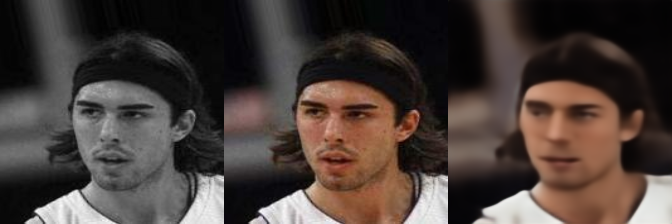

In [87]:
test_on_image(val_img_dir[967:], autoencoder, device, img_dim=IMG_DIM)

In [55]:
torch.save(autoencoder.state_dict(), WEIGHT_PATH)

In [269]:
def colourize(i_dir, autoencoder, input_shape):
    # coloured = cv2.resize(cv2.imread('img_align_celeba/' + val_img_dir[93]), (224, 224))
    # coloured = cv2.resize(cv2.imread('black-and-white-portrait-tips-3107.jpg'), (224, 224))
    coloured = cv2.resize(cv2.imread(i_dir), (input_shape[0], input_shape[1]))

    gray_coloured = cv2.cvtColor(cv2.cvtColor(coloured, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    test_image = gray_coloured.astype(np.float32) / 255
    test_image = np.reshape(test_image, (1, input_shape[0], input_shape[1], 3))
    test_image = np.transpose(test_image, (0,3,1,2))
    test_image = torch.from_numpy(test_image).to(device)
    
    with torch.no_grad():
        autoencoder.eval()
        y_hat = autoencoder(test_image)
        y_hat = y_hat.cpu().data.numpy()
        y_hat = np.transpose(y_hat, (0,2,3,1))
        # y_hat = np.rollaxis(y_hat, 3, 1)
        y_hat = y_hat * 255
        output = np.reshape(y_hat, (input_shape[0], input_shape[1], 3))

    blended = cv2.addWeighted(gray_coloured.astype(np.float32),0.5, output, 0.7, 0)

    hsv = cv2.cvtColor(blended, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    # h += value # 4
    s += 0.1 # 5
    # v += value # 6
    final_hsv = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    font = cv2.FONT_HERSHEY_SIMPLEX

    output = cv2.resize(output, (input_shape[0], input_shape[1]))
    cv2.rectangle(output, (0,0),(100,20),(0,0,0),cv2.FILLED)
    cv2.putText(output, 'Net. Output', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    
    cv2.rectangle(gray_coloured, (0,0),(100,20),(0,0,0), cv2.FILLED)
    cv2.putText(gray_coloured, 'Gray Image', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

    cv2.rectangle(coloured, (0,0),(90,20),(0,0,0), cv2.FILLED)
    cv2.putText(coloured, 'Ori. Image', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)


    cv2.rectangle(blended, (0,0),(70,20),(0,0,0),cv2.FILLED)
    cv2.putText(blended, 'Blended', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)

    cv2.rectangle(enhanced, (0,0),(82,20),(0,0,0),cv2.FILLED)
    cv2.putText(enhanced, 'Enhanced', (3, 15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    
    blank_ver_line = np.array([[[255] * 3] * 50] * 224)
    print(blank_ver_line.shape)

    test_result = np.concatenate((gray_coloured, output, blended, enhanced, blank_ver_line, coloured), axis=1)
    cv2_imshow(cv2.resize(test_result, (1120,224)))

(224, 50, 3)


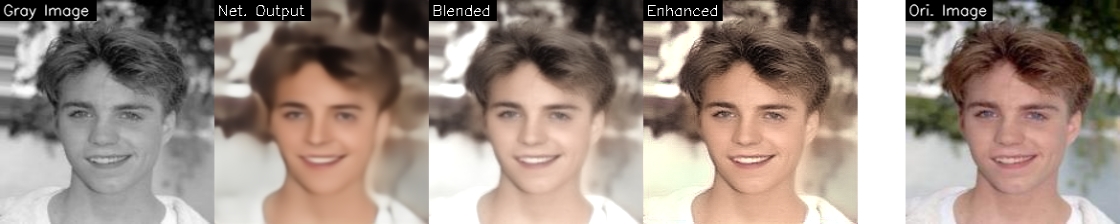

In [270]:
for i_dir in random.sample(val_img_dir, 1):
    colourize('img_align_celeba/' + i_dir, autoencoder, (224, 224, 3))

(224, 50, 3)


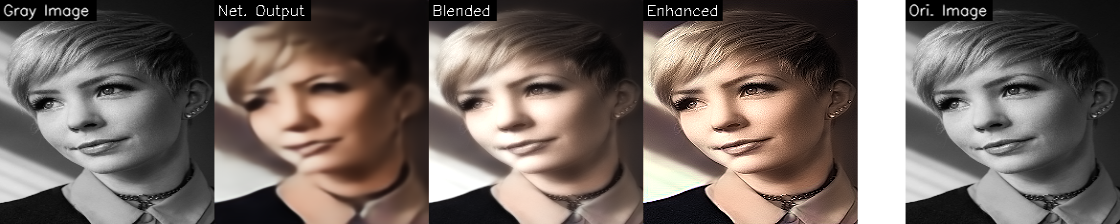

In [284]:
colourize('<path to image>', autoencoder, (224, 224, 3))